
 ```bash
$ sudo apt-get update
$ sudo apt-get install mahimahi python-pip -y
$ sudo apt-get install python3-pip
$ pip3 install -r requirements.txt

$ # This needs to run every time you restart the computer
$ sudo sysctl -w net.ipv4.ip_forward=1
 ```



```python

mahimahi_settings = {
    'delay': 100,
    'queue_size': 1,
    'trace_file': TRACE_FILES['114.68MBPS']
}

run_with_mahi_settings(mahimahi_settings, 10, [Sender(port, TahoeStrategy(10, 1))])
```



###

All congestion control strategies must inherit from `SenderStrategy`, and implement the methods `next_packet_to_send` and `process_ack`. See the `FixedWindowStrategy` in `src/strategies.py` for the simplest example of this. Other strategies including TahoeStrategy is also included.

 ## More Details

 ### Trace Files

 The trace files were taken from [this repo](https://github.com/StanfordSNR/indigo/tree/master/env)

 This repository comes with a number of trace files in the `traces/` folder. These were taken from [this repo](https://github.com/StanfordSNR/indigo/tree/master/env). Each of these is a list of timestamps
 at which the link can send a 1500 byte packet, and it is used to set the bandwidth of the network. For a 12mbps
 (1500 bytes), it would contain numbers matching:

 ```
 1
 2
 3
 4
 ...
 ```

In [ ]:
import socket
import select
import json
import time
import matplotlib.pyplot as plt
from typing import Dict, List, Optional
from src.helpers import run_with_mahi_settings, get_open_udp_port
from src.senders import Sender
from src.strategies import SenderStrategy, FixedWindowStrategy


In [ ]:
TRACE_FILES = {
    '0.57MBPS': '0.57mbps-poisson.trace',
    '2.64MBPS': '2.64mbps-poisson.trace',
    '3.04MBPS': '3.04mbps-poisson.trace',
    '100.42MBPS': '100.42mbps.trace',
    '114.68MBPS': '114.68mbps.trace'
}

## Fixed Window Strategy (No CC)

[sender] Connected to receiver: 100.64.0.10:38017

Results for sender 49582:
Total Acks: 23377
Num Duplicate Acks: 22419
% duplicate acks: 95.901955
Throughput (bytes/s): 1277.333333
Average RTT (ms): 973.516416


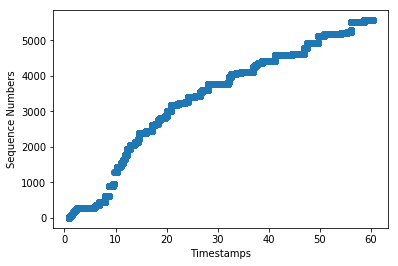

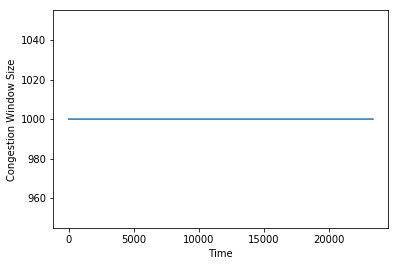

In [ ]:
mahimahi_settings = {
    'delay': 88,
    'queue_size': 26400,
    'trace_file': TRACE_FILES['2.64MBPS']
}

port = get_open_udp_port()
run_with_mahi_settings(mahimahi_settings, 60, [Sender(port, FixedWindowStrategy(1000))])

# CC with Tahoe

In [ ]:
class TahoeStrategy(SenderStrategy):
    def __init__(self, slow_start_thresh: int, initial_cwnd: int) -> None:
        self.slow_start_thresh = slow_start_thresh

        self.cwnd = initial_cwnd
        self.fast_retransmit_packet = None
        self.time_since_retransmit = None
        self.retransmitting_packet = False
        self.ack_count = 0

        self.duplicated_ack = None
        self.slow_start_thresholds = []

        super().__init__()

    def window_is_open(self) -> bool:
        # next_ack is the sequence number of the next acknowledgement
        # we are expecting to receive. If the gap between next_ack and
        # seq_num is greater than the window, then we need to wait for
        # more acknowledgements to come in.
        return self.seq_num - self.next_ack < self.cwnd

    def next_packet_to_send(self) -> Optional[str]:
        send_data = None
        if self.retransmitting_packet and self.time_of_retransmit and time.time() - self.time_of_retransmit > 1:
            # The retransmit packet timed out--resend it
            self.retransmitting_packet = False

        if self.fast_retransmit_packet and not self.retransmitting_packet:
            # Logic for resending the packet
            self.unacknowledged_packets[self.fast_retransmit_packet['seq_num']]['send_ts'] = time.time()
            send_data = self.fast_retransmit_packet
            serialized_data = json.dumps(send_data)
            self.retransmitting_packet = True

            self.time_of_retransmit = time.time()

        elif self.window_is_open():
            send_data = {
                'seq_num': self.seq_num,
                'send_ts': time.time()
            }

            self.unacknowledged_packets[self.seq_num] = send_data
            self.seq_num += 1
        else:
            # Check to see if any segments have timed out. Note that this
            # isn't how TCP actually works--traditional TCP uses exponential
            # backoff for computing the timeouts
            for seq_num, segment in self.unacknowledged_packets.items():
                if time.time() - segment['send_ts'] > 4:
                    self.unacknowledged_packets[seq_num]['send_ts'] = time.time()
                    return json.dumps(segment)

        if send_data is None:
            return None
        else:
            return json.dumps(send_data)


    def process_ack(self, serialized_ack: str) -> None:
        ack = json.loads(serialized_ack)
        if ack.get('handshake'):
            return

        self.total_acks += 1
        self.times_of_acknowledgements.append(((time.time() - self.start_time), ack['seq_num']))


        if self.unacknowledged_packets.get(ack['seq_num']) is None:
            # Duplicate ack

            self.num_duplicate_acks += 1
            if self.duplicated_ack and ack['seq_num'] == self.duplicated_ack['seq_num']:
                self.curr_duplicate_acks += 1
            else:
                self.duplicated_ack = ack
                self.curr_duplicate_acks = 1

            if self.curr_duplicate_acks == 3:
                # Received 3 duplicate acks, retransmit
                self.fast_retransmit_packet = self.unacknowledged_packets[ack['seq_num'] + 1]
                self.slow_start_thresh = int(max(1, self.cwnd/2))
                self.cwnd = 1
        elif ack['seq_num'] >= self.next_ack:
            if self.fast_retransmit_packet:
                self.fast_retransmit_packet = None
                self.retransmitting_packet = False
                self.curr_duplicate_acks = 0
                self.seq_num = ack['seq_num'] + 1

            # Acknowledge all packets where seq_num < ack['seq_num']
            self.unacknowledged_packets = {
                k:v
                for k,v in
                self.unacknowledged_packets.items()
                if k > ack['seq_num']
            }
            self.next_ack = max(self.next_ack, ack['seq_num'] + 1)
            self.ack_count += 1
            self.sent_bytes = ack['ack_bytes']
            rtt = float(time.time() - ack['send_ts'])
            self.rtts.append(rtt)
            if self.cwnd < self.slow_start_thresh:
                # In slow start
                self.cwnd += 1
            elif (ack['seq_num'] + 1) % self.cwnd == 0:
                # In congestion avoidance
                self.cwnd += 1

        self.cwnds.append(self.cwnd)
        self.slow_start_thresholds.append(self.slow_start_thresh)

[sender] Connected to receiver: 100.64.0.6:50700

Results for sender 53812:
Total Acks: 356153
Num Duplicate Acks: 3932
% duplicate acks: 1.104020
Throughput (bytes/s): 116953.333333
Average RTT (ms): 211.311396


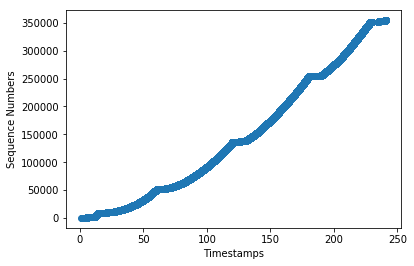

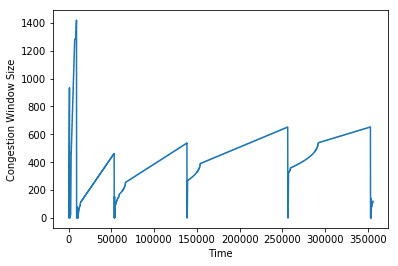

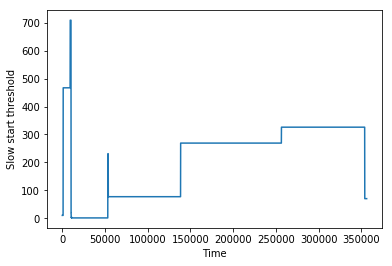

In [ ]:
mahimahi_settings = {
    'delay': 88,
    'queue_size': 26400,
    'trace_file': TRACE_FILES['2.64MBPS']
}


port = get_open_udp_port()
run_with_mahi_settings(mahimahi_settings, 240, [Sender(port, TahoeStrategy(10, 1))])

## High Bandwidth



[sender] Connected to receiver: 100.64.0.2:39378

Results for sender 37783:
Total Acks: 649011
Num Duplicate Acks: 4017
% duplicate acks: 0.618942
Throughput (bytes/s): 214706.666667
Average RTT (ms): 183.205910


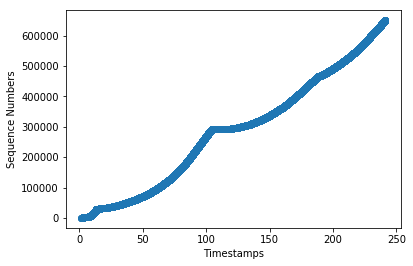

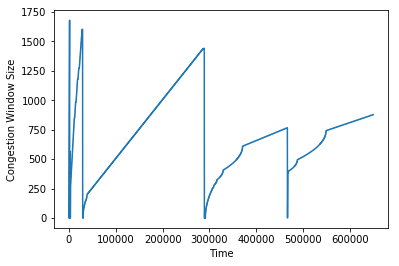

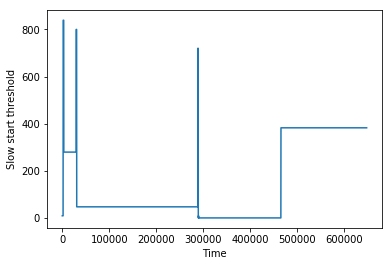

In [ ]:
mahimahi_settings = {
    'delay': 88,
    'queue_size': 1104620,
    'trace_file': TRACE_FILES['100.42MBPS']
}

port = get_open_udp_port()
run_with_mahi_settings(mahimahi_settings, 240, [Sender(port, TahoeStrategy(10, 1))])

## Low Bandwidth, 2 Fixed Window Senders

Two fixed sendoers with no CC.

[sender] Connected to receiver: 100.64.0.12:36280

[sender] Connected to receiver: 100.64.0.12:36280

Results for sender 59055:
Total Acks: 10345
Num Duplicate Acks: 10049
% duplicate acks: 97.138714
Throughput (bytes/s): 394.666667
Average RTT (ms): 1963.733075


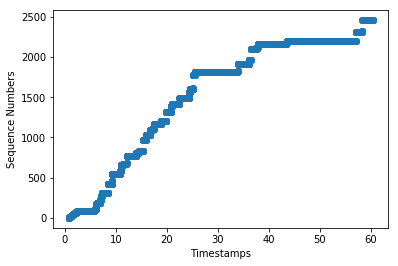

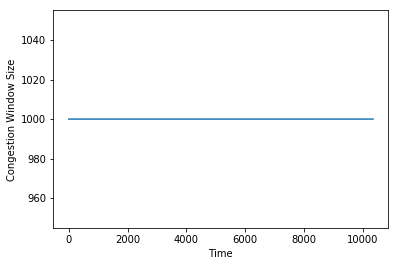



Results for sender 56771:
Total Acks: 3341
Num Duplicate Acks: 3037
% duplicate acks: 90.900928
Throughput (bytes/s): 405.333333
Average RTT (ms): 1360.758694


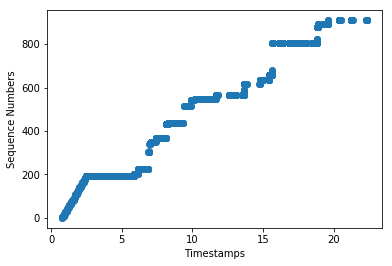

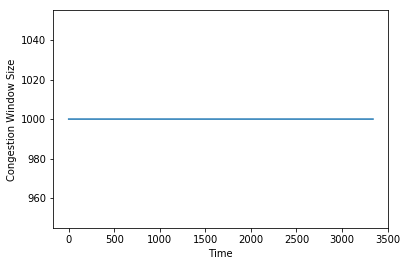

In [ ]:
mahimahi_settings = {
    'delay': 88,
    'queue_size': 26400,
    'trace_file': TRACE_FILES['2.64MBPS']
}

port = get_open_udp_port()
port2 = get_open_udp_port()
run_with_mahi_settings(mahimahi_settings, 60, [Sender(port, FixedWindowStrategy(1000)), Sender(port2, FixedWindowStrategy(1000))])

## Low Bandwidth, 1 Fixed Window, 1 Tahoe

1 Fixed Window and 1 Tahoe

[sender] Connected to receiver: 100.64.0.6:46944

[sender] Connected to receiver: 100.64.0.6:46944

Results for sender 57126:
Total Acks: 7
Num Duplicate Acks: 2
% duplicate acks: 28.571429
Throughput (bytes/s): 6.666667
Average RTT (ms): 1730.737257


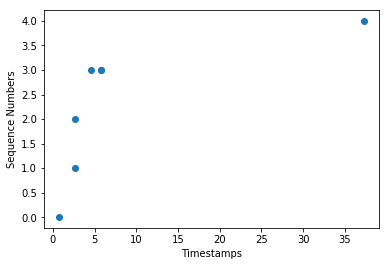

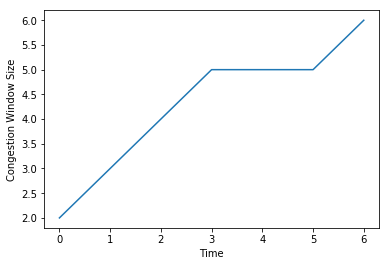

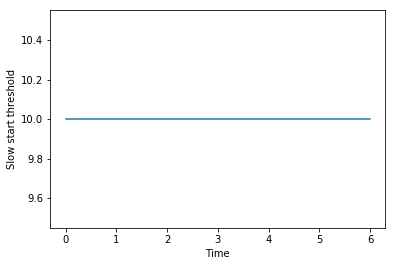


Results for sender 36758:
Total Acks: 10891
Num Duplicate Acks: 10292
% duplicate acks: 94.500046
Throughput (bytes/s): 798.666667
Average RTT (ms): 1500.501963


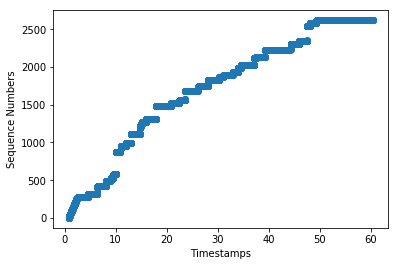

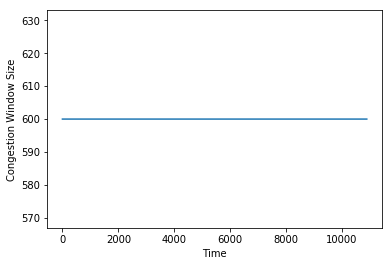

In [ ]:
mahimahi_settings = {
    'delay': 88,
    'queue_size': 26400,
    'trace_file': TRACE_FILES['2.64MBPS']
}

port = get_open_udp_port()
port2 = get_open_udp_port()
run_with_mahi_settings(mahimahi_settings, 60, [Sender(port, TahoeStrategy(10, 1)), Sender(port2, FixedWindowStrategy(600))])

## Low Bandwidth, 2 Tahoe Senders


[sender] Connected to receiver: 100.64.0.16:33207

[sender] Connected to receiver: 100.64.0.16:33207

Results for sender 45861:
Total Acks: 183693
Num Duplicate Acks: 2066
% duplicate acks: 1.124703
Throughput (bytes/s): 60415.666667
Average RTT (ms): 248.982606


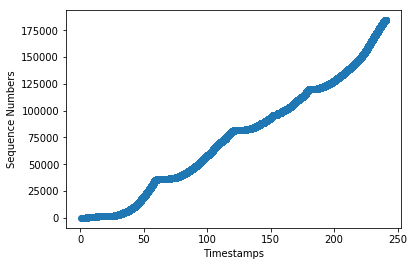

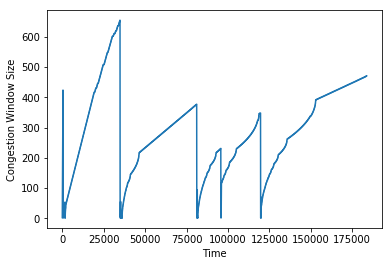

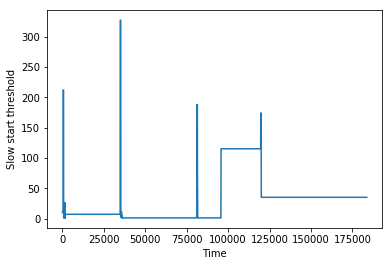


Results for sender 35767:
Total Acks: 198109
Num Duplicate Acks: 2406
% duplicate acks: 1.214483
Throughput (bytes/s): 64878.333333
Average RTT (ms): 242.212587


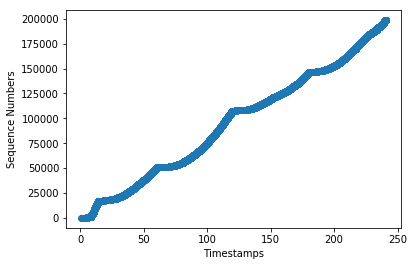

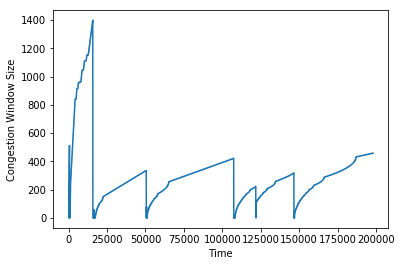

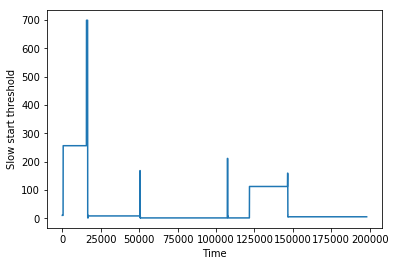

In [ ]:
mahimahi_settings = {
    'delay': 88,
    'queue_size': 26400,
    'trace_file': TRACE_FILES['2.64MBPS']
}

port = get_open_udp_port()
port2 = get_open_udp_port()
run_with_mahi_settings(mahimahi_settings, 120, [Sender(port, TahoeStrategy(10, 1)), Sender(port2, TahoeStrategy(10, 1))])